In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

In [35]:
excel_data_df = pd.ExcelFile(r'../data/egg.xlsx')
excel_data_df = excel_data_df.parse(excel_data_df.sheet_names[0])

In [3]:
result_df = pd.ExcelFile(r'../data/egg-result.xlsx')
result_df = result_df.parse(result_df.sheet_names[0])
result_set = result_df.iloc[:, 1].tolist()

In [4]:
for idx, header in enumerate(excel_data_df.columns.tolist()):
    print(idx, header)

0 Dấu thời gian
1 Địa chỉ email
2 Số báo danh của bạn (Sử dụng SBD đã được gửi qua email)
3 Mục tiêu của bạn khi tham gia vào câu lạc bộ EGG? (Tối thiểu số lựa chọn để tối ưu hóa mục tiêu bạn nhé)
4 Nếu được vào câu lạc bộ và vượt qua các khóa training, tương lai bạn muốn trở thành ai?
5 Tại sao bạn lại chọn nguyện vọng như trên? Bạn có những thế mạnh gì tương ứng nguyện vọng đã chọn. (Câu hỏi này rất quan trọng, hãy thể hiện nhiều nhất có thể nhé)
6 Liệt kê các thành tích nổi bật của em (nếu có)
7 Bạn có thể dành bao nhiêu thời gian cho các hoạt động chung của câu lạc bộ?
8 Bạn có thể dành bao nhiêu thời gian để làm bài tập trong các hoạt động training kiến thức?
9 Bạn có kỹ năng đặc biệt nào khác không?
10 Bạn có mong muốn chia sẻ kiến thức cho cộng đồng không? Đối với các hoạt động được chia sẻ trên fanpage EGG, nếu bạn là một thành viên câu lạc bộ, bạn sẽ cải tiến nó như thế nào để mang lại nhiều giá trị hơn cho cộng đồng IT?


In [36]:
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Nhân sự")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Đối ngoại")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Chuyên môn")]
excel_data_df.reset_index(drop=True, inplace=True)
filter = [0, 1, 5, 7, 9, 11, 14, 15, 16, 17, 18, 19, 22, 23, 24, 26, 28, 30, 31, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 52, 53, 55, 58, 60, 61, 65, 68, 69, 74, 77, 84, 86, 87, 88, 89, 96, 97, 98, 102, 104, 106, 107, 108, 110, 111, 112, 113, 114, 116, 117, 120, 127, 129, 134, 135, 137, 138, 139, 140, 140, 142, 145, 146, 149, 152, 154, 155]
excel_data_df.fillna("", inplace = True)
excel_data_df = excel_data_df.iloc[filter]
excel_data_df.reset_index(drop=True, inplace=True)
# identity = list(excel_data_df.index.values)
identity = excel_data_df.iloc[:, 1].tolist()

In [6]:
import sys; sys.path.insert(0, '..')
from app.loader import loader
from app.ssmc_fcm import SSMC_FCM

u:\DATN\algo-clustering-service\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Algo Clustering Config:
 {
    "SERVICE_NAME": "ALGO_CLUSTERING",
    "STOPWORD_PATH": "u:\\DATN\\algo-clustering-service/resources/vn_stopword.txt",
    "FEATURES_PATH": "u:\\DATN\\algo-clustering-service/resources/features.txt"
}
No GPU available, using the CPU instead.


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
fields_chosen = {
    # 3: (loader.multilabel_binarizing, 1),
    # 4: (loader.multilabel_binarizing, 1),
    # 5: (loader.feature_engineering, 1),
    6: (loader.feature_engineering, 1),
    # 7: (loader.multilabel_binarizing, 1),
    # 8: (loader.multilabel_binarizing, 1),
    9: (loader.multilabel_binarizing, 1),
    # 10: (loader.feature_engineering, 1),
}

In [37]:
from datetime import datetime
vectors = {}
for id_field, config in fields_chosen.items():
    start = datetime.now()
    func = config[0]
    raw_data = excel_data_df.iloc[:, id_field].tolist()
    data = func(raw_data)
    vectors[id_field] = data
    print(f"{round(100 * (list(fields_chosen).index(id_field) + 1) / len(fields_chosen), 2)}% ({datetime.now() - start})")

50.0% (0:00:06.049648)
100.0% (0:00:00.001521)


In [38]:
cluster_fields = [
    # 3,
    # 4,
    # 5,
    6,
    # 7,
    # 8,
    9,
    # 10,
]
dataset = None
data_field_len = []
data_field_weight = []
for idx, id_field in enumerate(cluster_fields):
    data = np.array(vectors[id_field])
    dataset = data if idx == 0 else np.hstack((dataset, data))
    data_field_len.append(data.shape[1])
    data_field_weight.append(fields_chosen[id_field][1])
dataset.shape, data_field_len, data_field_weight

((77, 804), [768, 36], [1, 1])

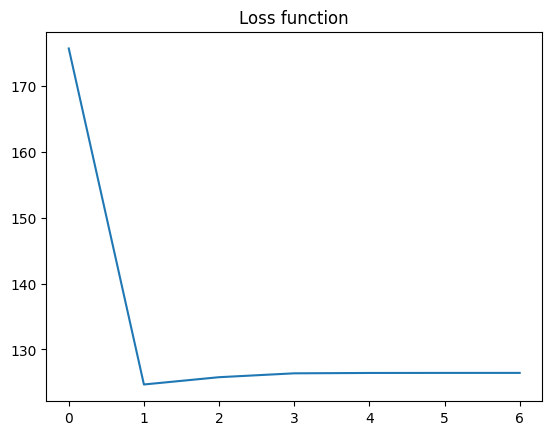

loss functions: 
[175.71824016691866, 124.68351721982911, 125.78940414203231, 126.37783672654109, 126.43298865883891, 126.44156441518126, 126.44303813454123]


In [43]:
supervised_set = [
    [
    
    ]
]
ssmc_fcm = SSMC_FCM(
    dataset=dataset, 
    fields_len=data_field_len,
    fields_weight=[1, 2],
    n_clusters=5, 
    identity=identity,
    supervised_set=supervised_set, 
)
ssmc_fcm.clustering()
# ssmc_fcm.show_cluster_members()
ssmc_fcm.show_loss_function()

In [44]:
identity_mapping = {iden: idx for idx, iden in enumerate(identity)}
for cluster in ssmc_fcm.pred_labels:
    count = sum([cluster.count(x) for x in result_set])
    print(f"Accuracy: {round(100 * count / len(result_set), 2)}% ({count} in {len(cluster)})")
    # print([identity.index(i) for i in cluster])
    display(excel_data_df.loc[[identity.index(i) for i in cluster]].iloc[:, [1, *cluster_fields]])

Accuracy: 32.5% (13 in 35)


,Địa chỉ email,Liệt kê các thành tích nổi bật của em (nếu có),Bạn có kỹ năng đặc biệt nào khác không?
0,leducdientin92018@gmail.com,giải nhất tình tin học\ngiải nhì olympic tin h...,Em chỉ có nhiệt huyết
1,thanh.hh204787@sis.hust.edu.vn,"CPA (4 kì): 3.9\nĐiểm A: Toán rời rạc, CTDL&GT...",Em chỉ có nhiệt huyết
4,thongphil18@gmail.com,giải nhì HSG vật lí tỉnh.,Em chỉ có nhiệt huyết
8,thanh.hq225090@sis.hust.edu.vn,Giải ba môn Toán kì thi HSG cấp tỉnh,Em chỉ có nhiệt huyết
10,shiraishi2612@gmail.com,-Giải Ba HSGQG môn Vật lý 2021-2022\n-Giải Nhấ...,"Làm trợ giảng, Em chỉ có nhiệt huyết"
13,nguyentuandatk16a@gmail.com,Nhì tỉnh tin học cấp tỉnh (C++)\nKhuyến khích ...,Em chỉ có nhiệt huyết
15,nguyentatcuong251204@gmail.com,Giải KK toán cấp thành phố 2021-2022,Em chỉ có nhiệt huyết
17,truongngocmai3@gmail.com,Giải nhì hsg toán cấp Tỉnh,"Tổ chức sự kiện, Em chỉ có nhiệt huyết"
19,damtoan321@gmail.com,em có giải nhì toán tỉnh năm lớp 12,Em chỉ có nhiệt huyết
20,dangduckhai44@gmail.com,Giải 3 khoa học kĩ thuật cấp quốc gia,"Làm trợ giảng, Sử dụng các công cụ thiết kế ản..."


Accuracy: 0.0% (0 in 0)


,Địa chỉ email,Liệt kê các thành tích nổi bật của em (nếu có),Bạn có kỹ năng đặc biệt nào khác không?


Accuracy: 20.0% (8 in 12)


,Địa chỉ email,Liệt kê các thành tích nổi bật của em (nếu có),Bạn có kỹ năng đặc biệt nào khác không?
2,dung.work2408@gmail.com,Điểm toiec nội bộ: 760\nThực tập web 6 tháng t...,
5,thang.dv224899@sis.hust.edu.vn,Giải Khuyến Khích Qgia năm 2021\nGiải ba tỉnh ...,"Làm trợ giảng, Em chỉ có nhiệt huyết"
24,nguyenngocyen.nny24@gmail.com,- Trưởng ban tài chính đối ngoại Toán Mô Hình ...,"Chụp ảnh, quay phim, Tổ chức sự kiện"
31,dangvietchinh694@gmail.com,Giải 3 HSG hoá cấp tỉnh,"Em chỉ có nhiệt huyết, Có thể sáng tạo ý tưởng..."
37,hdl243004@gmail.com,"IELTS 7.0,IT2 Hust","Em chỉ có nhiệt huyết, Em biết cách sử dụng và..."
40,nguyenhuunamhoa2004@gmail.com,Về mặt thanh tích tùy không tham gia vào các k...,"Viết blog IT, Làm trợ giảng, Em chỉ có nhiệt h..."
49,hung123ka5@gmail.com,+) Em là học sinh chuyên Tin trường THPT Chuyê...,"Làm trợ giảng, Em chỉ có nhiệt huyết"
51,manhhungtran2004@gmail.com,Trong khoảng thời gian ôn thi THPTQG 2022 em k...,"Sử dụng các công cụ thiết kế ảnh, video,..., T..."
52,ducanhcttp@gmail.com,Thủ khoa điểm chuyên Toán đầu vào Chuyên Trần ...,"Làm trợ giảng, Em chỉ có nhiệt huyết"
53,huydimmo@gmail.com,Về học tập: 27+ điểm thi thptqg\n ...,Tổ chức sự kiện


Accuracy: 2.5% (1 in 1)


,Địa chỉ email,Liệt kê các thành tích nổi bật của em (nếu có),Bạn có kỹ năng đặc biệt nào khác không?
75,nguyenanhhao2506@gmail.com,-Học chương trình tài năng điện tử viễn thông....,"Làm trợ giảng, Em chỉ có nhiệt huyết, vẽ vời"


Accuracy: 15.0% (6 in 29)


,Địa chỉ email,Liệt kê các thành tích nổi bật của em (nếu có),Bạn có kỹ năng đặc biệt nào khác không?
3,minhhaizdr@gmail.com,Em từng lên ý tưởng cho sự kiện 20/10 hồi lớp ...,"Viết blog IT, Làm trợ giảng, Tổ chức sự kiện"
6,nguyenbaolinh1925@hotmail.com,Giải nhất KHKT của huyện và khuyến khích của t...,"Em chỉ có nhiệt huyết, Hiện tại, em chỉ có nhi..."
7,huybla166@gmail.com,Đạt giải nhì thành phố môn Vật Lý (lớp 9)\nĐiể...,"Tổ chức sự kiện, Em chỉ có nhiệt huyết"
9,dvtiendat.work@gmail.com,Giải Khuyến khích HSG Tin cấp Thành phố (TP Hà...,"Tổ chức sự kiện, Em chỉ có nhiệt huyết"
11,quanghunglion@gmail.com,Thành tích cấp 3:\nGiải Nhất học sinh giỏi Toá...,Làm trợ giảng
12,kimduyminh2124@gmail.com,Giải nhì cuộc thi sáng tạo thanh thiếu nhi ( t...,"Sử dụng các công cụ thiết kế ảnh, video,..., E..."
14,Tri.HM224461@sis.hust.edu.vn,Em đã đạt 2 giải khuyến khích môn Tin học lập ...,"Viết blog IT, Em chỉ có nhiệt huyết, Em nghĩ n..."
16,nam0837305039@gmail.com,"12 năm học sinh giỏi, có các giải nhất nhì của...","Làm trợ giảng, Tổ chức sự kiện, Em chỉ có nhiệ..."
18,nhhoang12122004@gmail.com,Đỗ khoa công nghệ thông tin Global ICT của đại...,"Làm trợ giảng, Em chỉ có nhiệt huyết"
23,nguyennt090904@gmail.com,Đạt giải 3 HSG Toán cấp tỉnh năm lớp 9\nĐạt gi...,"Tổ chức sự kiện, Em chỉ có nhiệt huyết"
